# Load Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install scanpy
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 5.0 MB/s 
     |████████████████████████████████| 11.2 MB 38.0 MB/s 
     |████████████████████████████████| 96 kB 4.9 MB/s 
     |████████████████████████████████| 88 kB 7.4 MB/s 
     |████████████████████████████████| 959 kB 59.8 MB/s 
     |████████████████████████████████| 1.1 MB 64.5 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=40f0b6a8e110b9ff6b737dd232ff0609671d32fd9526bfa8c822aa08c74cc11b
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=9b173897eb5a9c8b9f017f8842fe249b2f641978fb01042946e1437add866903
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 5.0 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scanpy 1.9.1 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.


In [3]:
import numpy as np 
import pandas as pd 
import scanpy as sc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy import stats
import seaborn as sns

# Pancreas I

In [4]:
Pancreas_adata = sc.read_text("/content/drive/My Drive/ML for genomics project group /Data/Pancreas Data/Processed/Pancreas_LogX_CellCycleRegressedOut.txt", delimiter = '\t', first_column_names=None)
sc.pp.scale(Pancreas_adata)
Pancreas_adata

AnnData object with n_obs × n_vars = 2209 × 26179
    var: 'mean', 'std'

In [5]:
PancreasMetadata = pd.read_csv("/content/drive/My Drive/ML for genomics project group /Data/Pancreas Data/Processed/PancreasMetadata.csv")
Pancreas_adata.obs['Cell Type'] = PancreasMetadata['Cell type'].values
Pancreas_adata.obs['Cell Type'].unique()

array(['γ', 'α', 'β', 'acinar', 'ε', 'unclassified exocrine', 'ductal',
       'δ', 'unclassified endocrine', 'endothelial', 'co-expression',
       'PSC', 'mast', 'MHC'], dtype=object)

In [6]:
PancreasCellID = []
for item in PancreasMetadata['Cell ID'].values:
  PancreasCellID.append(item)
Pancreas_adata.obs_names = PancreasCellID
Pancreas_adata.obs_names

Index(['HP1502401_H13', 'HP1502401_J14', 'HP1502401_B14', 'HP1502401_A14',
       'HP1502401_C14', 'HP1502401_G14', 'HP1502401_E14', 'HP1502401_L14',
       'HP1502401_M14', 'HP1502401_K14',
       ...
       'HP1526901T2D_M7', 'HP1526901T2D_N16', 'HP1526901T2D_C8',
       'HP1526901T2D_H2', 'HP1526901T2D_I16', 'HP1526901T2D_F7',
       'HP1525301T2D_K3', 'HP1525301T2D_J10', 'HP1526901T2D_N8',
       'HP1526901T2D_A8'],
      dtype='object', length=2209)

In [7]:
PancreasGenes = pd.read_csv("/content/drive/My Drive/ML for genomics project group /Data/Pancreas Data/Processed/Pancreas_Genelist.txt",header=None)
PancreasGenelist = []
for item in PancreasGenes.values.tolist():
  PancreasGenelist.append(item[0])
Pancreas_adata.var_names = PancreasGenelist
Pancreas_adata.var_names

Index(['SGIP1', 'AZIN2', 'CLIC4', 'AGBL4', 'NECAP2', 'SLC45A1', 'TGFBR3',
       'DBT', 'RFWD2', 'C1orf21',
       ...
       'KIR3DS1', 'KIR2DL5B', 'KIR2DS2', 'KIR2DS1', 'KIR2DL2', 'KIR2DL4',
       'KIR2DS3', 'KIR2DS2', 'BIVM-ERCC5', 'ERCC_30000:mix1_7500:mix2'],
      dtype='object', length=26179)

In [8]:
PancreasMarkers = pd.read_csv("/content/drive/My Drive/ML for genomics project group /Data/Pancreas Data/Processed/sparseAE_pancreas_markers.csv")
PancreasMarkers

,Unnamed: 0,official gene symbol,cell type
0,0,NOS3,Endothelial cells
1,1,SH3GL2,Alpha cells
2,2,NTRK1,Beta cells
3,3,BACH2,MHC
4,4,FAM84A,Mast cells
...,...,...,...
871,871,FLT1,Endothelial cells
872,872,MGP,Pancreatic stellate cells
873,873,ASS1,MHC
874,874,VSTM2L,Epsilon cells


In [9]:
# Make cell type names between PacreasMarkers and Pancreas_adata['cell type'] match

for idx in np.where(PancreasMarkers['cell type'] == 'Acinar cells')[0]:
  PancreasMarkers.iloc[idx,2] = 'acinar'
for idx in np.where(PancreasMarkers['cell type'] == 'Alpha cells')[0]:
  PancreasMarkers.iloc[idx,2] = 'α'
for idx in np.where(PancreasMarkers['cell type'] == 'Beta cells')[0]:
  PancreasMarkers.iloc[idx,2] = 'β'
for idx in np.where(PancreasMarkers['cell type'] == 'Delta cells')[0]:
  PancreasMarkers.iloc[idx,2] = 'δ'
for idx in np.where(PancreasMarkers['cell type'] == 'Ductal cells')[0]:
  PancreasMarkers.iloc[idx,2] = 'ductal'
for idx in np.where(PancreasMarkers['cell type'] == 'Epsilon cells')[0]:
  PancreasMarkers.iloc[idx,2] = 'ε'
for idx in np.where(PancreasMarkers['cell type'] == 'Gamma (PP) cells')[0]:
  PancreasMarkers.iloc[idx,2] = 'γ'
for idx in np.where(PancreasMarkers['cell type'] == 'Pancreatic stellate cells')[0]:
  PancreasMarkers.iloc[idx,2] = 'PSC'
for idx in np.where(PancreasMarkers['cell type'] == 'Endothelial cells')[0]:
  PancreasMarkers.iloc[idx,2] = 'endothelial'
for idx in np.where(PancreasMarkers['cell type'] == 'Mast cells')[0]:
  PancreasMarkers.iloc[idx,2] = 'mast'
for idx in np.where(PancreasMarkers['cell type'] == 'Enteroendocrine cells')[0]:
  PancreasMarkers.iloc[idx,2] = 'unclassified endocrine'

pd.unique(PancreasMarkers['cell type'])

array(['endothelial', 'α', 'β', 'MHC', 'mast', 'PSC',
       'unclassified endocrine', 'acinar', 'ε', 'ductal', 'δ', 'γ'],
      dtype=object)

Marker Genes P-Values


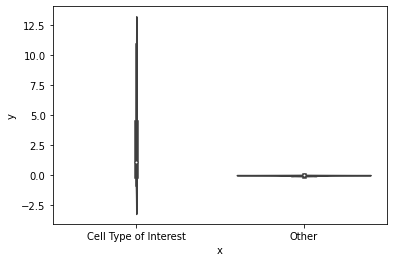

endothelial = 4.175831805607409e-21


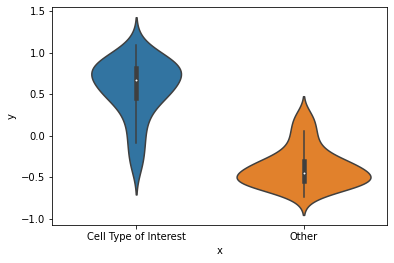

α = 7.812089925138447e-27


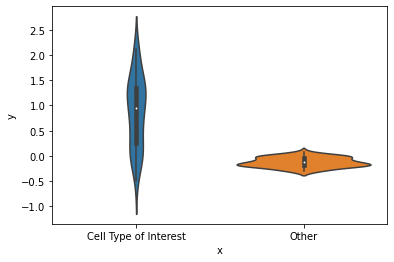

β = 4.639848814176993e-14


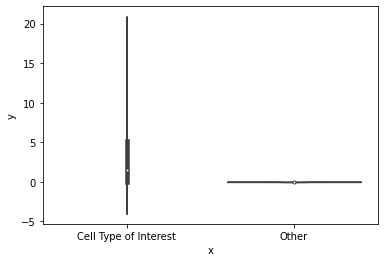

MHC = 4.963193495023886e-30


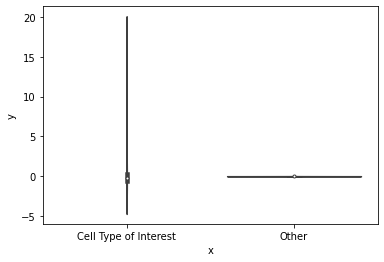

mast = 0.00024934456419106656


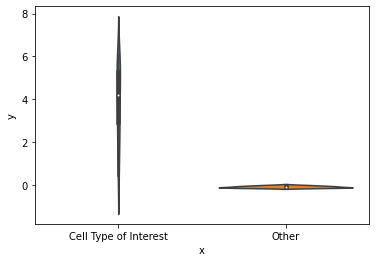

PSC = 4.1220501951497133e-17


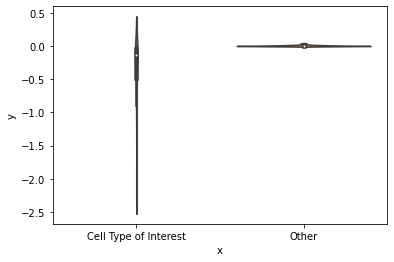

unclassified endocrine = 7.827552175199731e-05


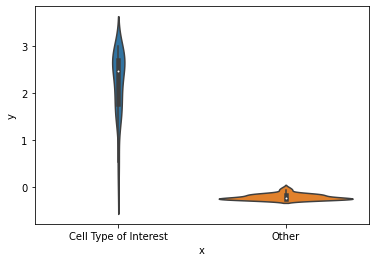

acinar = 2.0218561216029892e-41


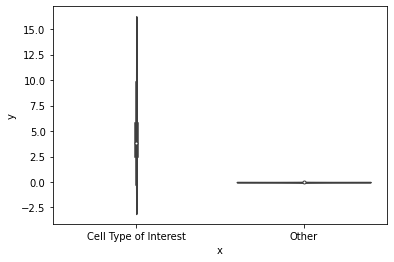

ε = 1.8878548318810053e-15


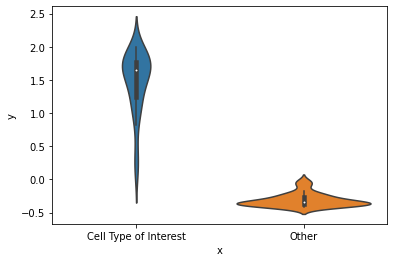

ductal = 2.431932811404914e-33


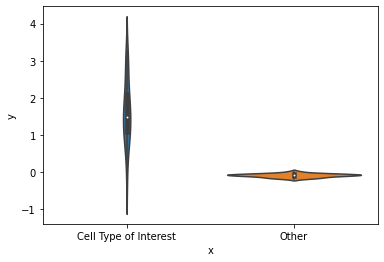

δ = 7.932379591273011e-12


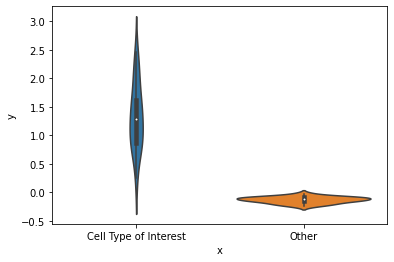

γ = 3.4619773967766846e-13


In [10]:
MarkerGenePValues = []

print('Marker Genes P-Values')

for CellType in pd.unique(PancreasMarkers['cell type']):
  CellTypeIndices = []
  PancreasMarkers.iloc[np.asarray(np.where(PancreasMarkers['cell type'] == CellType))[0,:],:]['official gene symbol'].values

  for i in PancreasMarkers.iloc[np.asarray(np.where(PancreasMarkers['cell type'] == CellType))[0,:],:]['official gene symbol'].values:
    if len(np.where(Pancreas_adata.var_names == i)[0]) > 0:
      CellTypeIndices.append(np.where(Pancreas_adata.var_names == i)[0][0])

  CellTypeIndices = [l.tolist() for l in CellTypeIndices]

  CellPopExpr = np.mean(Pancreas_adata[np.where(Pancreas_adata.obs['Cell Type'] == CellType)[0], CellTypeIndices].X, axis=0)
  OtherPopExpr = np.mean(Pancreas_adata[np.where(Pancreas_adata.obs['Cell Type'] != CellType)[0], CellTypeIndices].X, axis=0)

  Violin_df = pd.melt(pd.DataFrame({"Cell Type of Interest":CellPopExpr, "Other":OtherPopExpr}), 
                    var_name = 'x', 
                    value_name = 'y') 
  sns.violinplot(data = Violin_df, x = 'x', y = 'y')
  plt.show()

  tStat, pVal = stats.ttest_ind(CellPopExpr, OtherPopExpr)
  print(CellType + ' = ' + str(pVal) + '\r')
  MarkerGenePValues.append(pVal)

In [11]:
PancreasMarkerGeneQuality = pd.DataFrame({'cell_type': pd.unique(PancreasMarkers['cell type']), 
                                          'p_value': MarkerGenePValues})
PancreasMarkerGeneQuality

,cell_type,p_value
0,endothelial,4.175832e-21
1,α,7.812090e-27
2,β,4.639849e-14
3,MHC,4.963193e-30
4,mast,2.493446e-04
5,PSC,4.122050e-17
6,unclassified endocrine,7.827552e-05
7,acinar,2.021856e-41
8,ε,1.887855e-15
9,ductal,2.431933e-33


In [12]:
PancreasMarkerGeneQuality.to_csv("/content/drive/My Drive/ML for genomics project group /Data/Pancreas Data/Processed/Pancreas_MarkerGeneQuality.csv")

# GBM

In [5]:
# Read and process GBM data 

GBM_adata = sc.read_text("/content/drive/My Drive/ML for genomics project group /Data/GBM Data/Processed/GBM_Processed.txt", delimiter = '\t', first_column_names=None)

GBM_Metadata = pd.read_csv("/content/drive/My Drive/ML for genomics project group /Data/GBM Data/Processed/metadata2.csv")
GBM_adata.obs['Cell Type'] = GBM_Metadata['cell_assignment'].values

GBMGenes = pd.read_csv("/content/drive/My Drive/ML for genomics project group /Data/GBM Data/Processed/features2.tsv",header=None)
GBMGenelist = []
for item in GBMGenes.values.tolist():
  GBMGenelist.append(item[0])
GBM_adata.var_names = GBMGenelist
GBM_adata.var_names

Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2MP1',
       'A4GALT', 'A4GNT', 'AA06',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=23686)

In [6]:
pd.unique(GBM_adata.obs['Cell Type'])

array(['Macrophage', 'Malignant', 'Oligodendrocyte', 'T-cell'],
      dtype=object)

In [7]:
GBMMarkers = pd.read_csv("/content/drive/My Drive/ML for genomics project group /Data/GBM Data/Processed/sparseAE_GBM_markers.csv")
GBMMarkers

,Unnamed: 0,official gene symbol,cell type
0,0,CD36,Macrophages
1,1,FCGR1A,Macrophages
2,2,PARP14,Macrophages
3,3,VLDLR,Oligodendrocytes
4,4,OPALIN,Oligodendrocytes
...,...,...,...
303,7,ATRX,Malignant
304,8,TP53,Malignant
305,9,PIK3CA,Malignant
306,10,RB1,Malignant


In [14]:
# Make cell type names between GBMMarkers and GBM_adata['cell type'] match

for idx in np.where(GBMMarkers['cell type'] == 'Macrophages')[0]:
  GBMMarkers.iloc[idx,2] = 'Macrophage'
for idx in np.where(GBMMarkers['cell type'] == 'Oligodendrocytes')[0]:
  GBMMarkers.iloc[idx,2] = 'Oligodendrocyte'
for idx in np.where(GBMMarkers['cell type'] == 'T cells')[0]:
  GBMMarkers.iloc[idx,2] = 'T-cell'

pd.unique(GBMMarkers['cell type'])

array(['Macrophage', 'Oligodendrocyte', 'T-cell', 'Malignant'],
      dtype=object)

Marker Genes P-Values


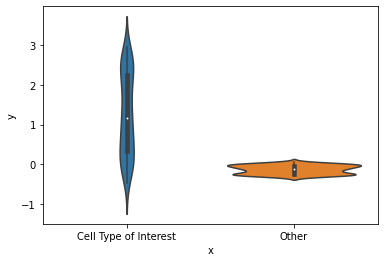

Macrophage = 1.1646400064716738e-36


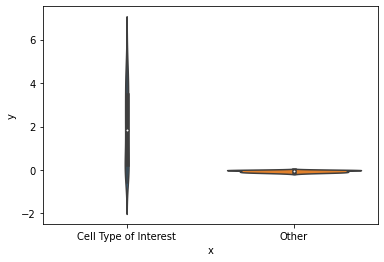

Oligodendrocyte = 8.055783837125147e-22


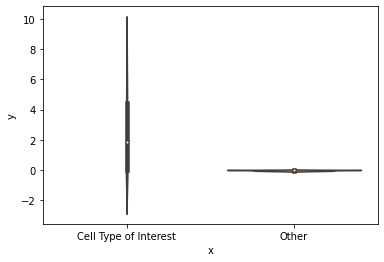

T-cell = 2.927678396259794e-15


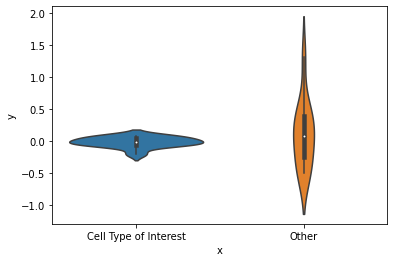

Malignant = 0.45214448165925814


In [15]:
GBM_MarkerGenePValues = []

print('Marker Genes P-Values')

for CellType in pd.unique(GBMMarkers['cell type']):
  CellTypeIndices = []
  GBMMarkers.iloc[np.asarray(np.where(GBMMarkers['cell type'] == CellType))[0,:],:]['official gene symbol'].values

  for i in GBMMarkers.iloc[np.asarray(np.where(GBMMarkers['cell type'] == CellType))[0,:],:]['official gene symbol'].values:
    if len(np.where(GBM_adata.var_names == i)[0]) > 0:
      CellTypeIndices.append(np.where(GBM_adata.var_names == i)[0][0])

  CellTypeIndices = [l.tolist() for l in CellTypeIndices]

  CellPopExpr = np.mean(GBM_adata[np.where(GBM_adata.obs['Cell Type'] == CellType)[0], CellTypeIndices].X, axis=0)
  OtherPopExpr = np.mean(GBM_adata[np.where(GBM_adata.obs['Cell Type'] != CellType)[0], CellTypeIndices].X, axis=0)

  Violin_df = pd.melt(pd.DataFrame({"Cell Type of Interest":CellPopExpr, "Other":OtherPopExpr}), 
                    var_name = 'x', 
                    value_name = 'y') 
  sns.violinplot(data = Violin_df, x = 'x', y = 'y')
  plt.show()

  tStat, pVal = stats.ttest_ind(CellPopExpr, OtherPopExpr)
  print(CellType + ' = ' + str(pVal) + '\r')
  GBM_MarkerGenePValues.append(pVal)

In [16]:
GBMMarkerGeneQuality = pd.DataFrame({'cell_type': pd.unique(GBMMarkers['cell type']), 
                                          'p_value': GBM_MarkerGenePValues})
GBMMarkerGeneQuality

,cell_type,p_value
0,Macrophage,1.164640e-36
1,Oligodendrocyte,8.055784e-22
2,T-cell,2.927678e-15
3,Malignant,4.521445e-01


In [17]:
GBMMarkerGeneQuality.to_csv("/content/drive/My Drive/ML for genomics project group /Data/GBM Data/Processed/GBMMarkerGeneQuality.csv")

# CellTypist Data

In [ ]:
adata_2000 = sc.read('celltypist_demo_folder/demo_2000_cells.h5ad', 
                     backup_url = 'https://celltypist.cog.sanger.ac.uk/Notebook_demo_data/demo_2000_cells.h5ad')
adata_2000.X = adata_2000.X.toarray()

# Regress out cell cycle scores
CT_CellCycleScores = pd.read_table("/content/drive/MyDrive/ML for genomics project group /Data/CellTypist Data/CellCycleScore.csv",
                                   delimiter=',')
adata_2000.obs['score_S'] = CT_CellCycleScores['score_S'].values
adata_2000.obs['score_G2M'] = CT_CellCycleScores['score_G2M'].values
sc.pp.regress_out(adata_2000, ['score_S', 'score_G2M'])

# Scale (zero-center) data
sc.pp.scale(adata_2000)

adata_2000

  0%|          | 0.00/34.1M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 2000 × 18950
    obs: 'cell_type', 'score_S', 'score_G2M'
    var: 'mean', 'std'

In [ ]:
CT_Markers = pd.read_csv("/content/drive/My Drive/ML for genomics project group /Data/CellTypist Data/biasedVAE_CTdata_markers.csv")
CT_Markers

,Unnamed: 0,official gene symbol,cell type
0,0,INMT,Endothelial cells
1,1,PLEC,Endothelial cells
2,2,IGHA1,Follicular B cells
3,3,CALCRL,Endothelial cells
4,4,GAS5,Follicular B cells
...,...,...,...
371,3,TIMD4,Kupffer cells
372,4,SNORD3D,Kupffer cells
373,5,EGR2,Kupffer cells
374,6,ECSCR,Kupffer cells


In [ ]:
for idx in np.where(CT_Markers['cell type'] == 'Gamma delta T cells')[0]:
  CT_Markers.iloc[idx,2] = 'gamma-delta T cells'

Marker Genes P-Values


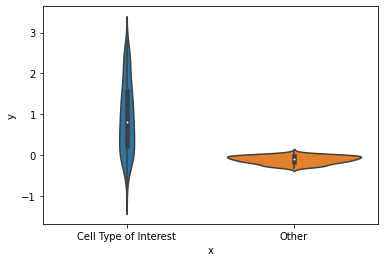

Endothelial cells = 4.012742814163996e-40


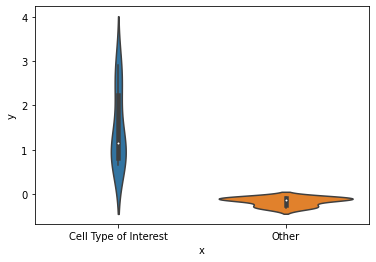

Follicular B cells = 3.241301246995763e-05


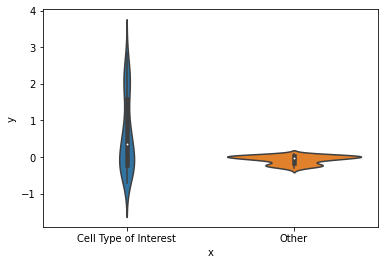

gamma-delta T cells = 7.916538234568423e-06


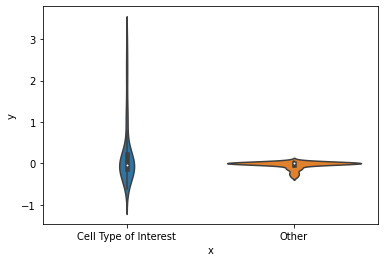

Mast cells = 8.478792290738334e-05


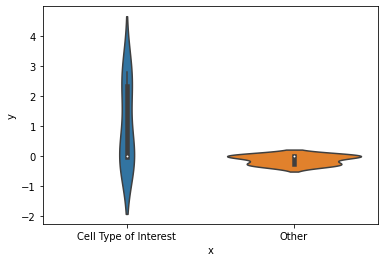

pDC = 0.04436107505393259


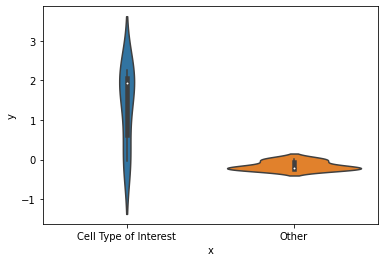

Plasma cells = 0.0017042817044621446


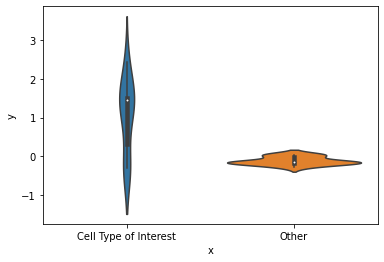

Macrophages = 0.0006489928952494977


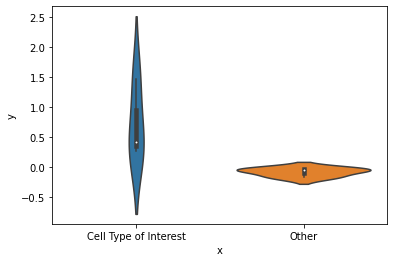

Neutrophil-myeloid progenitor = 0.10318502236378586


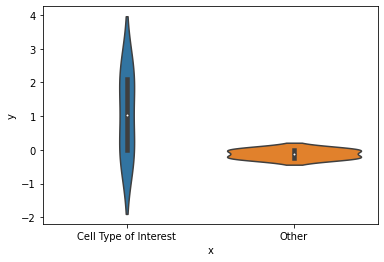

DC1 = 0.11018024675554025


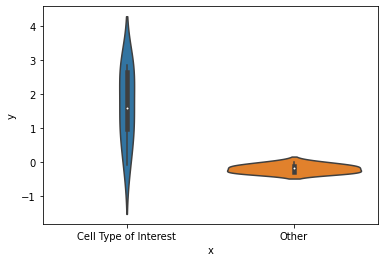

Kupffer cells = 0.0003175860158146705


In [ ]:
from scipy import stats
import seaborn as sns

MarkerGenePValues = []

print('Marker Genes P-Values')

for CellType in pd.unique(CT_Markers['cell type']):
  CellTypeIndices = []
  CT_Markers.iloc[np.asarray(np.where(CT_Markers['cell type'] == CellType))[0,:],:]['official gene symbol'].values

  for i in CT_Markers.iloc[np.asarray(np.where(CT_Markers['cell type'] == CellType))[0,:],:]['official gene symbol'].values:
    if len(np.where(adata_2000.var_names == i)[0]) > 0:
      CellTypeIndices.append(np.where(adata_2000.var_names == i)[0][0])

  CellTypeIndices = [l.tolist() for l in CellTypeIndices]

  CellPopExpr = np.mean(adata_2000[np.where(adata_2000.obs['cell_type'] == CellType)[0], CellTypeIndices].X, axis=0)
  OtherPopExpr = np.mean(adata_2000[np.where(adata_2000.obs['cell_type'] != CellType)[0], CellTypeIndices].X, axis=0)

  Violin_df = pd.melt(pd.DataFrame({"Cell Type of Interest":CellPopExpr, "Other":OtherPopExpr}), 
                    var_name = 'x', 
                    value_name = 'y') 
  sns.violinplot(data = Violin_df, x = 'x', y = 'y')
  plt.show()

  tStat, pVal = stats.ttest_ind(CellPopExpr, OtherPopExpr)
  print(CellType + ' = ' + str(pVal) + '\r')
  MarkerGenePValues.append(pVal)

In [ ]:
CT_MarkerGeneQuality = pd.DataFrame({'cell_type': pd.unique(CT_Markers['cell type']), 
                                          'p_value': MarkerGenePValues})
CT_MarkerGeneQuality

,cell_type,p_value
0,Endothelial cells,4.012743e-40
1,Follicular B cells,3.241301e-05
2,gamma-delta T cells,7.916538e-06
3,Mast cells,8.478792e-05
4,pDC,4.436108e-02
5,Plasma cells,1.704282e-03
6,Macrophages,6.489929e-04
7,Neutrophil-myeloid progenitor,1.031850e-01
8,DC1,1.101802e-01
9,Kupffer cells,3.175860e-04


In [ ]:
CT_MarkerGeneQuality.to_csv("/content/drive/My Drive/ML for genomics project group /Data/CellTypist Data/CT_MarkerGeneQuality.csv")

# PBMC

In [5]:
PBMC_adata_original = sc.read_text("/content/drive/MyDrive/ML for genomics project group /Data/PBMC Data/matrix.txt", delimiter = '\t', first_column_names=None)
PBMC_adata_original = PBMC_adata_original.T

# Load gene list 
PBMC_Genes = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/PBMC Data/features.txt")
PBMC_Genelist = []
for item in PBMC_Genes.values:
  PBMC_Genelist.append(item[0])
PBMC_adata_original.var_names = PBMC_Genelist

PBMC_Truth = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/PBMC Data/Ground_Truth_PBMC3k.csv")
PBMC_adata_original.obs['Cell Type'] = PBMC_Truth['orig_id'].values

PBMC_adata = PBMC_adata_original 
sc.pp.scale(PBMC_adata)

In [15]:
PBMC_Markers = pd.read_csv("/content/drive/My Drive/ML for genomics project group /Data/PBMC Data/biasedVAE_PBMC_markers.csv")
PBMC_Markers

,Unnamed: 0,official gene symbol,cell type
0,0,PTMA,B cells
1,1,GPX1,DC
2,2,KLRG1,MAIT cells
3,3,CCL5,Tem/Trm cytotoxic T cells
4,4,C1QA,Non-classical monocytes
...,...,...,...
82,3,EEF1G,Tcm/Naive helper T cells
83,4,TSHZ2,Tcm/Naive helper T cells
84,5,FCGRT,Tcm/Naive helper T cells
85,6,MALAT1,Tcm/Naive helper T cells


In [16]:
Predictions = PBMC_Markers['cell type'].values

j = 0
for i in PBMC_Markers['cell type'].values:
  if i == 'CD16+ NK cells':
    Predictions[j] = 'NK cells'
  if i == 'Tem/Trm cytotoxic T cells':
    Predictions[j] = 'CD8 T cells'
  if i == 'Non-classical monocytes':
    Predictions[j] = 'CD14+ Monocytes'
  if i == 'Tcm/Naive helper T cells':
    Predictions[j] = 'CD4 T cells'
  if i == 'MAIT cells':
    Predictions[j] = 'CD8 T cells'
  if i == 'Classical monocytes':
    Predictions[j] = 'CD14+ Monocytes'
  if i == 'Tem/Effector helper T cells':
    Predictions[j] = 'CD4 T cells'
  if i == 'Tcm/Naive cytotoxic T cells':
    Predictions[j] = 'CD8 T cells'
  if i == 'Regulatory T cells':
    Predictions[j] = 'CD4 T cells'
  if i == 'DC':
    Predictions[j] = 'Dendritic cells'
  j += 1

PBMC_Markers['cell type'] = Predictions

Marker Genes P-Values


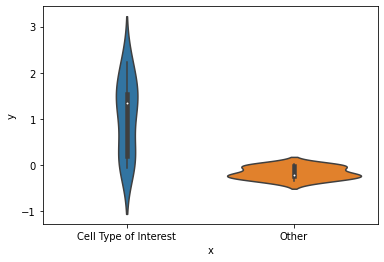

B cells = 8.160328299351438e-05


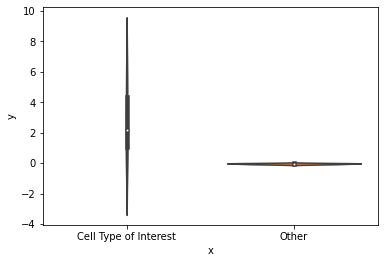

Dendritic cells = 0.018931646768167044


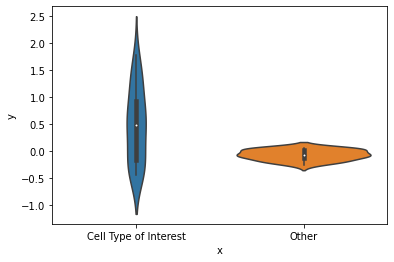

CD8 T cells = 0.000273332888884664


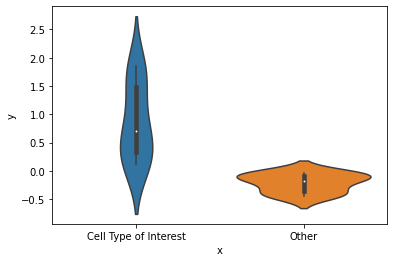

CD14+ Monocytes = 0.00034579657221649873


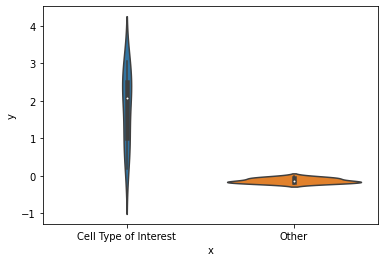

NK cells = 1.365684544637884e-06


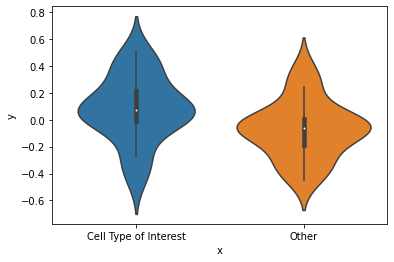

CD4 T cells = 0.023410816796322596


In [17]:
from scipy import stats
import seaborn as sns

MarkerGenePValues = []

print('Marker Genes P-Values')

for CellType in pd.unique(PBMC_Markers['cell type']):
  CellTypeIndices = []
  PBMC_Markers.iloc[np.asarray(np.where(PBMC_Markers['cell type'] == CellType))[0,:],:]['official gene symbol'].values

  for i in PBMC_Markers.iloc[np.asarray(np.where(PBMC_Markers['cell type'] == CellType))[0,:],:]['official gene symbol'].values:
    if len(np.where(PBMC_adata.var_names == i)[0]) > 0:
      CellTypeIndices.append(np.where(PBMC_adata.var_names == i)[0][0])

  CellTypeIndices = [l.tolist() for l in CellTypeIndices]

  CellPopExpr = np.mean(PBMC_adata[np.where(PBMC_adata.obs['Cell Type'] == CellType)[0], CellTypeIndices].X, axis=0)
  OtherPopExpr = np.mean(PBMC_adata[np.where(PBMC_adata.obs['Cell Type'] != CellType)[0], CellTypeIndices].X, axis=0)

  Violin_df = pd.melt(pd.DataFrame({"Cell Type of Interest":CellPopExpr, "Other":OtherPopExpr}), 
                    var_name = 'x', 
                    value_name = 'y') 
  sns.violinplot(data = Violin_df, x = 'x', y = 'y')
  plt.show()

  tStat, pVal = stats.ttest_ind(CellPopExpr, OtherPopExpr)
  print(CellType + ' = ' + str(pVal) + '\r')
  MarkerGenePValues.append(pVal)

In [18]:
PBMC_MarkerGeneQuality = pd.DataFrame({'cell_type': pd.unique(PBMC_Markers['cell type']), 
                                          'p_value': MarkerGenePValues})
PBMC_MarkerGeneQuality

,cell_type,p_value
0,B cells,0.000082
1,Dendritic cells,0.018932
2,CD8 T cells,0.000273
3,CD14+ Monocytes,0.000346
4,NK cells,0.000001
5,CD4 T cells,0.023411


In [19]:
PBMC_MarkerGeneQuality.to_csv("/content/drive/My Drive/ML for genomics project group /Data/PBMC Data/PBMC_MarkerGeneQuality.csv")

# Follicular Lymphoma

In [4]:
SceFollicula_adata = sc.read_h5ad("/content/drive/MyDrive/ML for genomics project group /Data/CellAssign Data /Source Data/sce_follicular_annotated_final.h5ad")

# Subsetting the cell barcodes 
SceFollicula_adata.obs = SceFollicula_adata.obs[['Sample']]
SceFollicula_adata.obs.drop(['Sample'], axis=1, inplace=True)

# Subsetting the gene name IDs 
SceFollicula_adata.var = SceFollicula_adata.var[['ID']]
SceFollicula_adata.var.set_index('ID', inplace=True)

# Load gene list 
FollicularLymphomaGenes = pd.read_table("/content/drive/MyDrive/ML for genomics project group /Data/CellAssign Data /Gene_Name.txt")
FollicularLymphomaGenelist = []
for item in FollicularLymphomaGenes.values.tolist():
  FollicularLymphomaGenelist.append(item[0])
SceFollicula_adata.var_names = FollicularLymphomaGenelist

# Load ground truth cell type labels 
SceFollicula_GroundTruth = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/CellAssign Data /GroundTruth_FollicularLymphoma.csv")
SceFollicula_adata.obs['Cell Type'] = SceFollicula_GroundTruth['x'].values

# Pre-process: log1p > regress out cell cycle score > HVG > scale
sc.pp.log1p(SceFollicula_adata)

# Regress out cell cycle scores
FL_CellCycleScores = pd.read_table("/content/drive/MyDrive/ML for genomics project group /Data/CellAssign Data /CellCycleScore.csv", delimiter = ',')
SceFollicula_adata.obs['score_S'] = FL_CellCycleScores['score_S'].values
SceFollicula_adata.obs['score_G2M'] = FL_CellCycleScores['score_G2M'].values
sc.pp.regress_out(SceFollicula_adata, ['score_S', 'score_G2M'])

sc.pp.highly_variable_genes(SceFollicula_adata)
sc.pp.scale(SceFollicula_adata)
SceFollicula_adata

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 9156 × 33694
    obs: 'Cell Type', 'score_S', 'score_G2M'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log.exprs.offset', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'logcounts'

In [22]:
FL_Markers = pd.read_csv("/content/drive/My Drive/ML for genomics project group /Data/CellAssign Data /biasedVAE_FollicularLymphoma_markers.csv")
FL_Markers

,Unnamed: 0,official gene symbol,cell type
0,0,NKG7,Cytotoxic T cells
1,1,CCL5,Cytotoxic T cells
2,2,MS4A1,B cells
3,3,CD79A,B cells
4,4,CD4,Tfh
5,5,CD74,B cells
6,6,CD19,B cells
7,7,CD8A,Cytotoxic T cells
8,8,CD8B,Cytotoxic T cells
9,9,CD3D,Cytotoxic T cells


In [23]:
GroundTruth = SceFollicula_adata.obs['Cell Type'].values
j = 0
for i in SceFollicula_adata.obs['Cell Type'].values:
  if i == 'B cells (malignant)':
    GroundTruth[j] = 'B cells'
  j += 1

SceFollicula_adata.obs['Cell Type'] = GroundTruth

Marker Genes P-Values


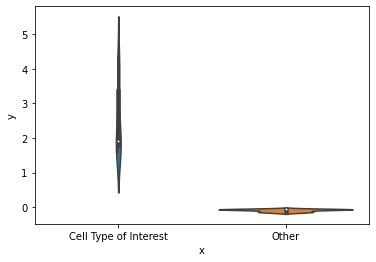

Cytotoxic T cells = 2.402173919282656e-11


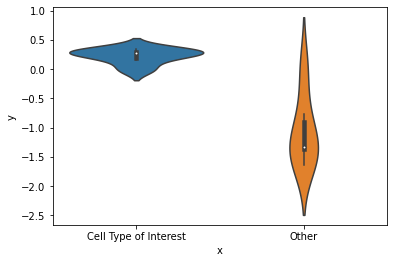

B cells = 0.0004771702707066779


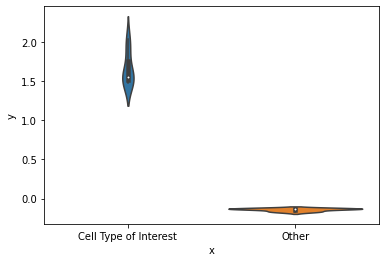

Tfh = 5.13033552210034e-11


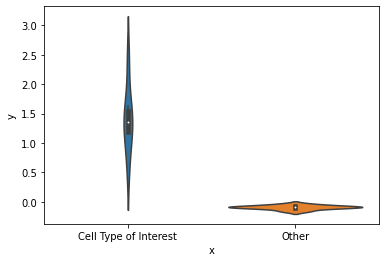

CD4 T cells = 1.0445986161272574e-05


In [24]:
MarkerGenePValues = []

print('Marker Genes P-Values')

for CellType in pd.unique(FL_Markers['cell type']):
  CellTypeIndices = []
  FL_Markers.iloc[np.asarray(np.where(FL_Markers['cell type'] == CellType))[0,:],:]['official gene symbol'].values

  for i in FL_Markers.iloc[np.asarray(np.where(FL_Markers['cell type'] == CellType))[0,:],:]['official gene symbol'].values:
    if len(np.where(SceFollicula_adata.var_names == i)[0]) > 0:
      CellTypeIndices.append(np.where(SceFollicula_adata.var_names == i)[0][0])

  CellTypeIndices = [l.tolist() for l in CellTypeIndices]

  CellPopExpr = np.mean(SceFollicula_adata[np.where(SceFollicula_adata.obs['Cell Type'] == CellType)[0], CellTypeIndices].X, axis=0)
  OtherPopExpr = np.mean(SceFollicula_adata[np.where(SceFollicula_adata.obs['Cell Type'] != CellType)[0], CellTypeIndices].X, axis=0)

  Violin_df = pd.melt(pd.DataFrame({"Cell Type of Interest":CellPopExpr, "Other":OtherPopExpr}), 
                    var_name = 'x', 
                    value_name = 'y') 
  sns.violinplot(data = Violin_df, x = 'x', y = 'y')
  plt.show()

  tStat, pVal = stats.ttest_ind(CellPopExpr, OtherPopExpr)
  print(CellType + ' = ' + str(pVal) + '\r')
  MarkerGenePValues.append(pVal)

In [25]:
FL_MarkerGeneQuality = pd.DataFrame({'cell_type': pd.unique(FL_Markers['cell type']), 
                                          'p_value': MarkerGenePValues})
FL_MarkerGeneQuality

,cell_type,p_value
0,Cytotoxic T cells,2.402174e-11
1,B cells,4.771703e-04
2,Tfh,5.130336e-11
3,CD4 T cells,1.044599e-05


In [26]:
FL_MarkerGeneQuality.to_csv("/content/drive/My Drive/ML for genomics project group /Data/CellAssign Data /FL_MarkerGeneQuality.csv")